# Activations & Gradients, Batch Normalization

This notebook explores the internal mechanics of Multi-Layer Perceptrons (MLPs), focusing on:

- Statistics of forward pass activations
- Backward pass gradients analysis
- Common pitfalls of improper scaling
- Diagnostic tools and visualizations for network health
- Introduction to Batch Normalization and its importance
- Understanding training challenges in deep neural networks

We'll examine why deep neural network training can be unstable and how Batch Normalization serves as a key innovation in addressing these challenges.

Useful links:
- "Kaiming init" paper: https://arxiv.org/abs/1502.01852
- BatchNorm paper: https://arxiv.org/abs/1502.03167
- Bengio et al. 2003 MLP language model paper (pdf): https://www.jmlr.org/papers/volume3/b...
- Good paper illustrating some of the problems with batchnorm in practice: https://arxiv.org/abs/2105.07576

*Note: Topics like Residual connections and Adam optimizer are not covered in this notebook.*





### The code we have so far

In [25]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt 

In [26]:
words = open('../data/names.txt', 'r').read().splitlines()

In [27]:
# build the vocabulary of characters and mappings to/from integers
charsSet = set(''.join(words)) 
chars = sorted(list(charsSet)) 

stoi = {s:i+1 for i,s in enumerate(chars)} # str to int dict
stoi['.'] = 0 # used to mark the end of a word
itos = {i+1:s for i,s in enumerate(chars)} # int to str dict
itos[0] = '.' 

In [28]:
block_size = 3 

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size # create the empty list of appropriate size 0's are "."
        for ch in w + '.': # add a dot at the end of the word 
            ix = stoi[ch] # retrieve the index of the ch
            X.append(context) 
            Y.append(ix) # target is the index of the ch

            #print(''.join(itos[i] for i in context), '--->', itos[ix]) # visually understand the X's and Y's
            context = context[1:] + [ix] # crop to the left and add the next index to the right 

    return torch.tensor(X), torch.tensor(Y)

import random 
random.seed(42)
random.shuffle(words) 

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

print(n1, n2)
print(Xtr.shape, Ytr.shape)
print(Xdev.shape, Ydev.shape)
print(Xte.shape, Yte.shape)

25626 28829
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [29]:
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 100 # number of neurons in the hidden layer of the MLP
vocab_size = len(chars) + 1

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),                generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                      generator=g)
W2 = torch.randn((n_hidden, vocab_size),        generator=g)
b2 = torch.randn(vocab_size,                    generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

6097


In [30]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed the chars into vectors
    embcat = emb.view(emb.shape[0],-1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation 
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)  

    # Backward pass
    for p in parameters:
        p.grad = None 
    loss.backward()

    # update 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad 

    # stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 18.5454
  10000/ 200000: 2.2443
  20000/ 200000: 2.1210
  30000/ 200000: 2.1859
  40000/ 200000: 2.0487
  50000/ 200000: 1.8602
  60000/ 200000: 2.1181
  70000/ 200000: 2.1337
  80000/ 200000: 2.1878
  90000/ 200000: 2.1133
 100000/ 200000: 2.2010
 110000/ 200000: 2.2665
 120000/ 200000: 2.6027
 130000/ 200000: 2.4345
 140000/ 200000: 2.0107
 150000/ 200000: 2.3355
 160000/ 200000: 1.9183
 170000/ 200000: 2.0670
 180000/ 200000: 2.2075
 190000/ 200000: 2.2650


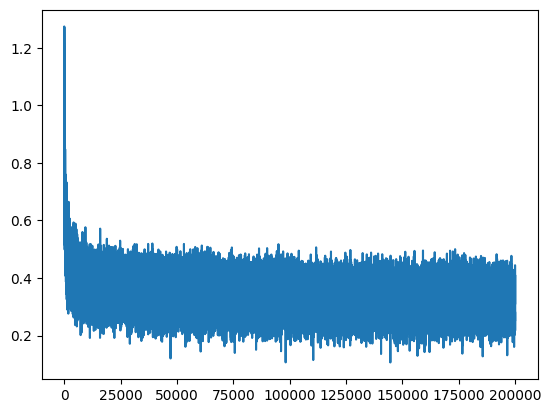

In [31]:
plt.plot(lossi)

In [32]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.1465883255004883
val 2.174128293991089


In [33]:
# sample from the model 
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        embcat = emb.view(1, -1) # concat into (N, block_size * n_embd)
        h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        probs = F.softmax(logits, dim=1)

        # sample from the distrib
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))



mora.
kayah.
seel.
nihahala.
emmaniendraeg.
adelyn.
eliah.
milopi.
eden.
sananar.
kayzion.
kalin.
shubergshiries.
kin.
reth.
konnie.
caylyn.
ged.
ryyah.
fael.


### Now, let's address the initialization 

First, we now that there is an issue because the loss looks like an hockey stick.

We can have a rough idea of the intial value we would excpect for the loss. Indeed, there are 27 possible characters and at intialization, the model should be guessing randomly. As we have no prior belief, we can assume that the model is guessing uniformly.

Therefore, the expected loss should be: -log(1/27) = 3.3 << 18 that we observe in the plot.

In [ ]:
# 4D example of the issue

# logits = torch.tensor([-3.0, 5.0, 0.0, 2.0])
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

# The bigger the initial values are the bigger the probability of having a huge loss is 
# That's because if they are all very differents, the probs are very wheighted (confident answers by the model)
# Thus, the neg log turns out big if we are guessing on the wrong bucket
# If they are all pretty much the same, it's better
# Solution : set them all really close to 0

(tensor([ -9.0021,  23.4563, -12.3504,  -5.9034]),
 tensor([8.0075e-15, 1.0000e+00, 2.8142e-16, 1.7753e-13]),
 tensor(35.8067))

Let's see the impact of this new initialization.

Logits are calculated as h @ W2 + b2. So if we wan't them close to 0, we must initialize b2 to 0 and W2 very small.

We will see later why we should avoid to initialize W2 to 0.

In [62]:
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 100 # number of neurons in the hidden layer of the MLP
vocab_size = len(chars) + 1

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                      generator=g)
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2 = torch.randn(vocab_size,                    generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

6097


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed the chars into vectors
    embcat = emb.view(emb.shape[0],-1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation 
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)  

    # Backward pass
    for p in parameters:
        p.grad = None 
    loss.backward()

    # update 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad 

    # stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

# from 18.5454
# to 3.3113 with b2 = 0 and W2 * 0.01
# It's now closer to this idea of uniform distrib

      0/ 200000: 3.3113


In [ ]:
logits[0] # way closer to 0 

tensor([-0.1266,  0.0205, -0.0193,  0.0304,  0.1225,  0.0484, -0.2076, -0.1809,
        -0.0220,  0.0178,  0.1027,  0.0908, -0.1996,  0.0426,  0.0204, -0.0842,
        -0.0894,  0.1147, -0.0301, -0.1151, -0.1579,  0.0195, -0.0061, -0.1180,
         0.0008,  0.0321, -0.0855], grad_fn=<SelectBackward0>)

Let's run the optimization again with this new initialization.

In [63]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed the chars into vectors
    embcat = emb.view(emb.shape[0],-1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation 
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)  

    # Backward pass
    for p in parameters:
        p.grad = None 
    loss.backward()

    # update 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad 

    # stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3113
  10000/ 200000: 2.3142
  20000/ 200000: 2.1829
  30000/ 200000: 2.1195
  40000/ 200000: 2.1354
  50000/ 200000: 1.9125
  60000/ 200000: 2.0492
  70000/ 200000: 2.1304
  80000/ 200000: 2.1849
  90000/ 200000: 2.1509
 100000/ 200000: 2.1357
 110000/ 200000: 2.2173
 120000/ 200000: 2.6701
 130000/ 200000: 2.1241
 140000/ 200000: 2.0376
 150000/ 200000: 2.2920
 160000/ 200000: 1.9707
 170000/ 200000: 2.0798
 180000/ 200000: 2.1422
 190000/ 200000: 2.2667


As excpected, the los starts at around 3.3

Also, the hockey stick shape is gone. And the final loss is a bit lower than before.

That's because before, the first iterations were spent to get the logits close to 0. Then, the model could start learning. Now, the model can learn from the start.

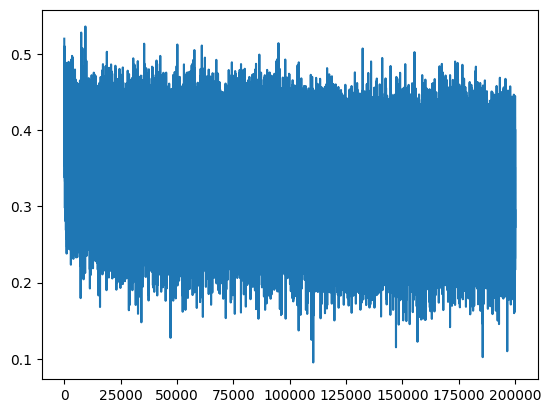

In [64]:
plt.plot(lossi)

In [65]:
split_loss('train')
split_loss('val')

train 2.1282122135162354
val 2.1653144359588623


### tanh Saturation

Now, we will see that the squashing effect of tanh put many of the neurons in "saturation" mode. It's a mode where the values are very close to -1 or 1. In this mode, the gradient is very small and the model can't learn properly. So we need to fix that.

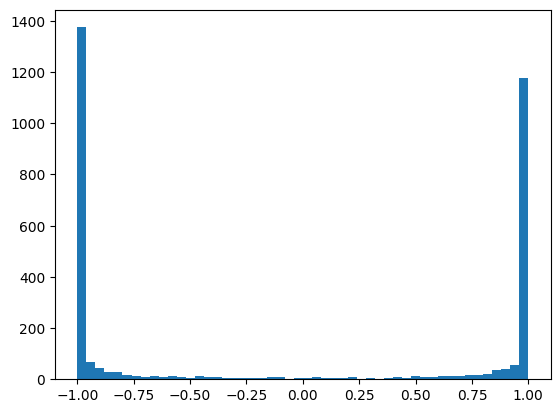

In [70]:
# Let's see the distribution of the values of h first

outputs = h.view(-1).tolist() # make it a long list of all the values
plt.hist(outputs, 50)
plt.show()

# As we've just said, the extrem majority of values are -1 or 1 creating a broad U shape

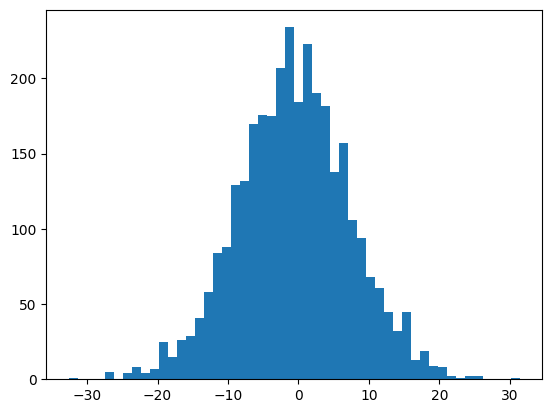

In [ ]:
# Let's ckeck the distribution of the preactivated values (the ones that are sent to tanh)

plt.hist(hpreact.view(-1).tolist(), 50)
plt.show()

# Now, we understand why the activated values are sent to 1 and -1
# The distribution is gaussian but with a huge variance. The values are ranging from -30 to 30
# So it's obvious that it's too large to evenly squash them all between -1 and 1 using tanh
# There necesserely is too much "activation "

#### Why is it problematic?

The gradient of tanh is defined as: 
$$
\frac{d}{dx} tanh(x) = 1 - tanh^2(x)
$$
So when tanh is close to -1 or 1, the gradient is very small. This means that the model can't learn properly because the gradient descent will be very slow.

Worst, if tanh is equal to -1 or 1, the gradient is equal to 0. This means that the optimization would stop.  (vanishing gradient problem)

It makes sense intuitively when we think about the plot of tanh. When values are close to -1 or 1, the slope is flat. So, changing the input a bit won't change the output much i.e there is no impact on the loss that is calculated thanks to the output.

Recap : we can change the weights and biases of this layer as much as we want, the output will not change. So the model can't learn.

Inversly, if the values are close to 0, the gradient is simply past through. Otherwise it shrinks proportionnaly to 1 - tanh^2(x). So the more we are far from 0, the more the gradient is small. 

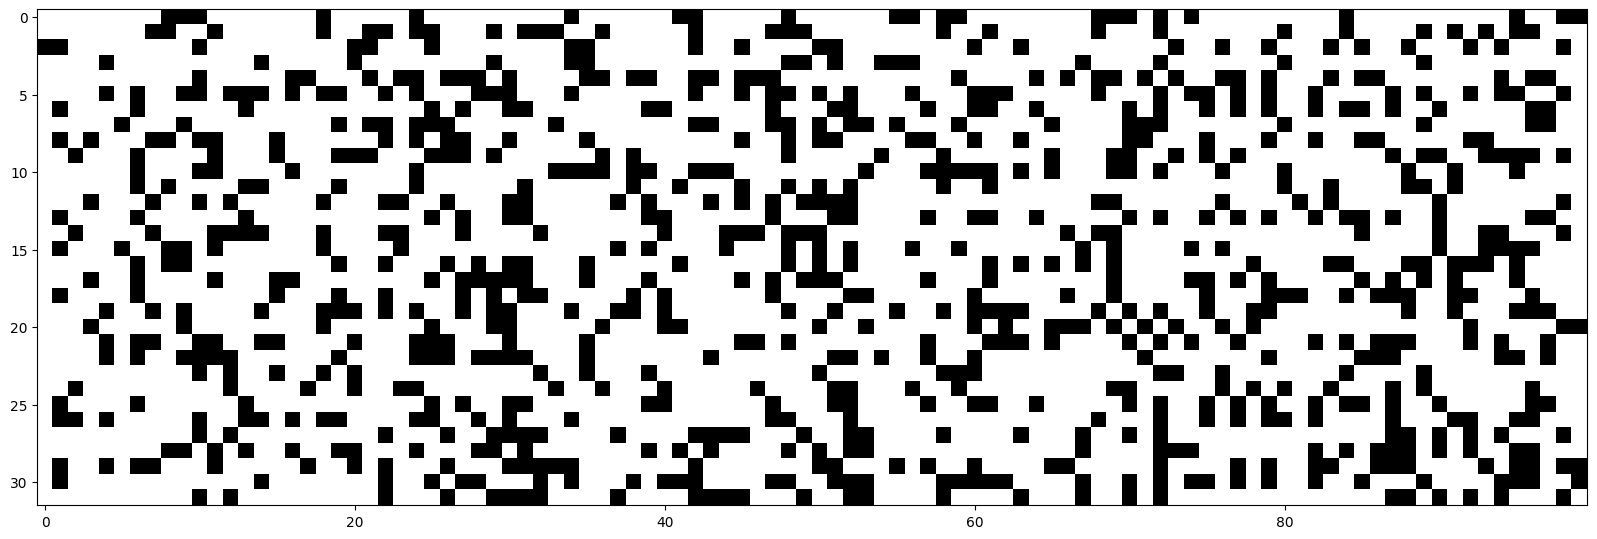

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.show()

# Here, every white cell is a neuron that is extremely activated >0.99

For the 32 examples, we can see that a lot of the 100 neurons are saturated. 

A dead neuron is a neuron that hasn't been activated at all for the entire batch. Here, the first one is activated only for 1 example. Which means that it's almost dead. 

Whenever a neuron is white for an example, it means that as stated above, the gradient is 0. So the model didn't learn anything for this example. It's a huge waste of time.

Note : The same problem applies to ReLU or Sigmoid as they have flat tails too. Conversely, the leaky ReLU doesn't have this problem.

### So how to fix that?

We must modify the distribution of the preactivated values.

But they are calulcated as emb @ W1 + b1. And emb are uniformed gaussian. So we have to reduce W1 and b1.

In [86]:
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 100 # number of neurons in the hidden layer of the MLP
vocab_size = len(chars) + 1

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2 = torch.randn(vocab_size,                    generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

6097


In [87]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed the chars into vectors
    embcat = emb.view(emb.shape[0],-1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation 
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)  

    # Backward pass
    for p in parameters:
        p.grad = None 
    loss.backward()

    # update 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad 

    # stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break


      0/ 200000: 3.3083


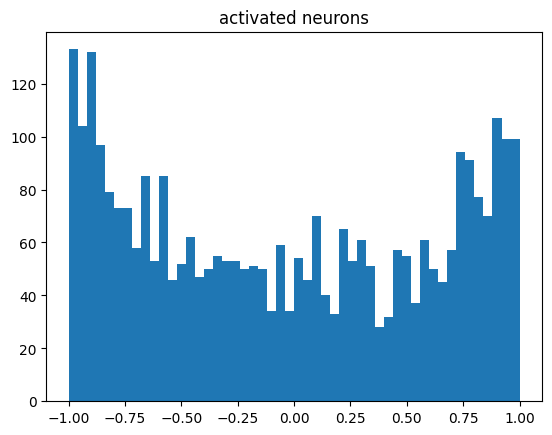

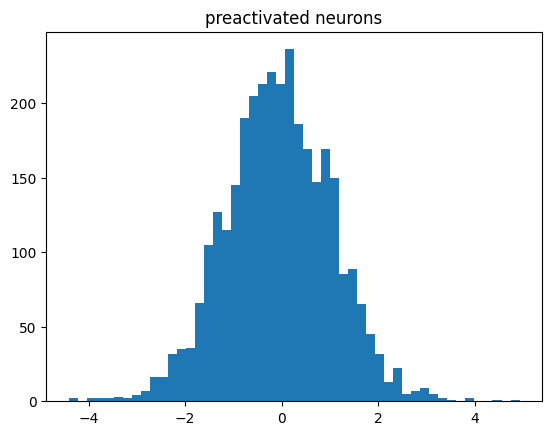

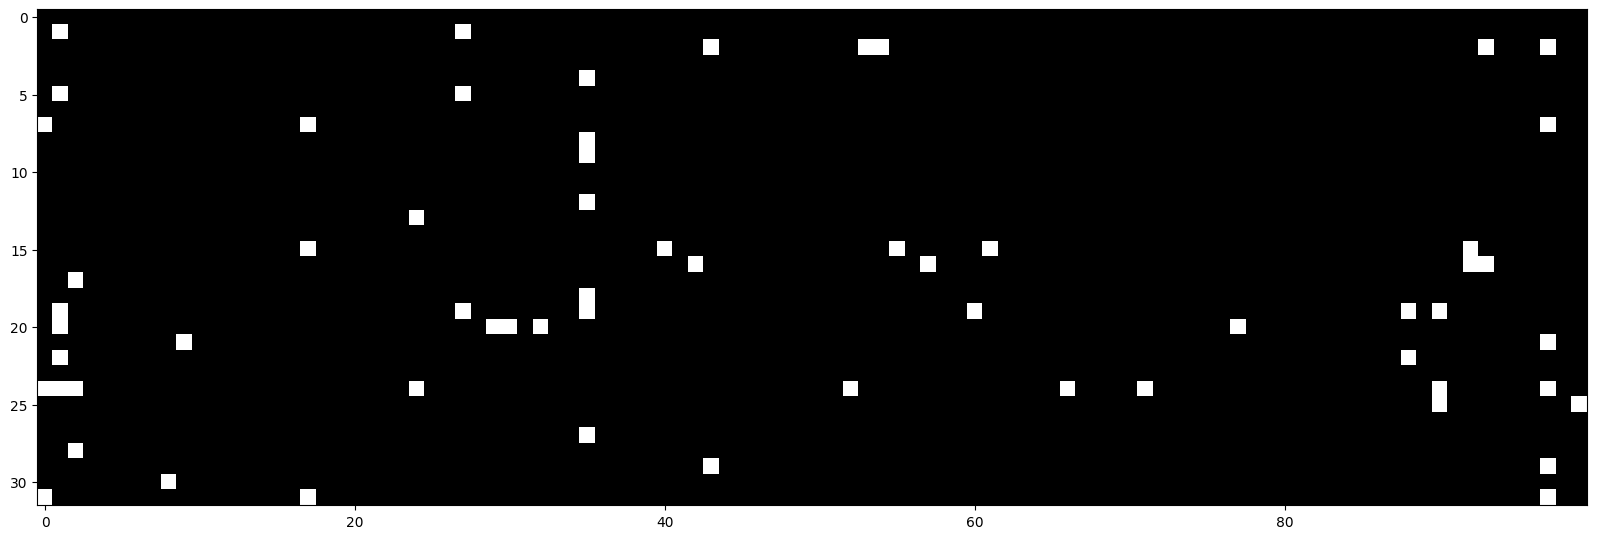

In [89]:

outputs = h.view(-1).tolist()
plt.hist(outputs, 50)
plt.title('activated neurons')
plt.show()

plt.hist(hpreact.view(-1).tolist(), 50)
plt.title('preactivated neurons')
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.show()

Now we have almost no saturation anymore and a good histograms of the preactivations and the activations.

Having the right initialization will help the model to learn faster and better.

This is espacially important for deep networks where these problems stack up and amplify making the training sometimes impossible.